In [1]:
import geopandas as gpd 

# Read in the data
data = gpd.read_parquet('../data/processed_datasets/SenfSeidl_joined_EPSG4326_FR.parquet').to_crs('epsg:32631')

def classify(x):
    if x == 1:
        return 'Storm/Black Beetle'
    elif x == 2:
        return 'Fire'
    elif x == 3:
        return 'Other'
    
data['class'] = data['cause'].apply(classify)

## Extent of the plot

<Axes: >

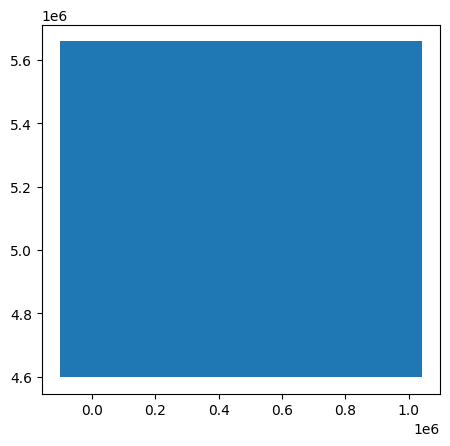

In [2]:
bounds = data.total_bounds
from utils import pol_from_points
pol = pol_from_points(bounds)

#put pol in a geodataframe 
extents = gpd.GeoDataFrame(geometry=[pol], crs='epsg:32631')
extents.plot()

## Choose colors

In [3]:
sorted(data['class'].unique())


['Fire', 'Other (logging, defoliation, etc)', 'Storm/Black Beetle']

In [4]:
#choosing color for barkbeetle and storm
import matplotlib.colors as mcolors
import numpy as np

biotic = mcolors.to_rgb('#91882f')
storm = mcolors.to_rgb('#325f8c')

storm_barkbeetle = (np.array(biotic) + np.array(storm)) / 2
mcolors.to_hex(storm_barkbeetle)

'#62745e'

In [5]:
#choosing color for barkbeetle and storm

a = mcolors.to_rgb('#848761')
b = mcolors.to_rgb('#91882f')
c = mcolors.to_rgb('#788745')

other = (np.array(a) + np.array(b) + np.array(c)) / 3
mcolors.to_hex(other)


'#848747'

## Plot the data

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_8190/3196169044.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


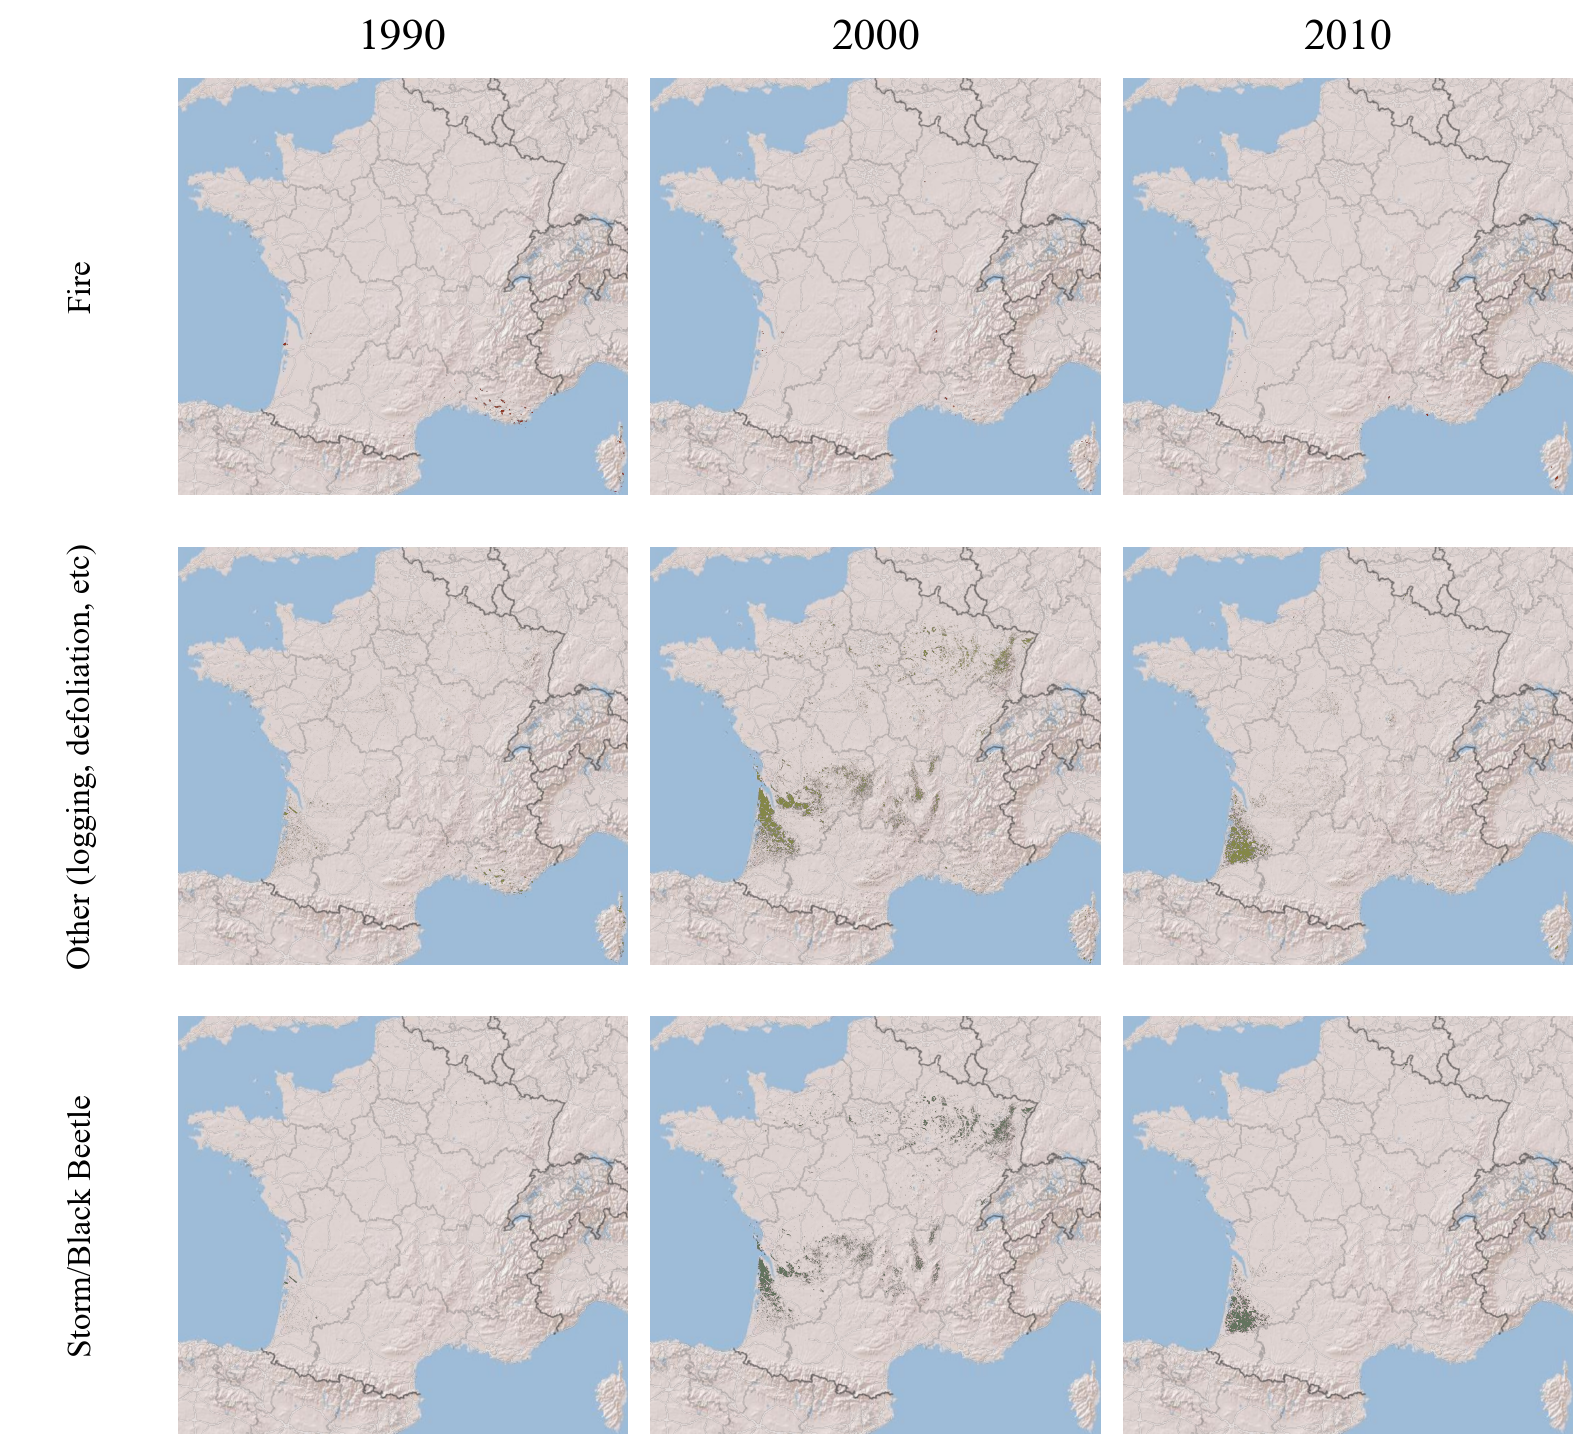

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import contextily as cx
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

all_classes = sorted(data['class'].unique())
# colors = ['#e0f794', '#757012', '#b8b48a', '#f03b20', '#0c6791', '#b6e3b6']
colors = ['#8f361f', '#848747' ,'#62745e']
years = [1990, 2000, 2010]

cmap = ListedColormap(colors)
# Create the normalization based on your classes. The +1 ensures the last boundary is inclusive.
boundaries = list(range(len(all_classes) + 1))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

color_mapping = {cls: color for cls, color in zip(all_classes, colors)}

def plot_yearly_class(gdf, year, class_, ax, xlim, ylim, color, zoom=None):
    # Filter the GeoDataFrame for the specified year
    gdf = gdf[ (gdf['class'] == class_) & (gdf['year'] == year) ]

    # Plot the disturbances
    gdf.plot(ax=ax, color=color, alpha=1, edgecolor=color, linewidth=0.01)
    # extent = [data['geometry'].centroid.x.min(), data['geometry'].centroid.x.max(), data['geometry'].centroid.y.min(), data['geometry'].centroid.y.max()]

    # ax.hexbin(gdf['geometry'].centroid.x, gdf['geometry'].centroid.y, C=gdf['geometry'].area , gridsize=25, extent=extent, mincnt=10, alpha=1, cmap='jet')
    # 
    extents.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
    source = cx.providers.Esri.WorldShadedRelief
    cx.add_basemap(ax, crs=data.crs, zoom=6, source=source, attribution=False)
    cx.add_basemap(ax, crs=data.crs, zoom=6, source=cx.providers.Stamen.TonerLines, attribution=False, alpha=0.5)
    #remove x, y axis details for clarity
    ax.set_axis_off()


    if xlim is None or ylim is None:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    # if zoom is not None:
    #     #create zoom with axins_inset
    #     axins = zoomed_inset_axes(ax, zoom[0], loc=1)
    #     (minx,miny,maxx,maxy) = zoom[1].bounds
    #     axins.set_xlim(minx, maxx)
    #     axins.set_ylim(miny, maxy)
    #     gdf.plot(ax=ax, color=color, alpha=1, edgecolor=color, linewidth=0.001)

    return xlim, ylim

#FIGURE
import matplotlib.gridspec as gridspec
from utils import wrap_pol

zoom = [[(10, wrap_pol(pol_from_points((5.432739,42.974511,7.410278,43.684757)), 4326, 32631)), None, None, None], 
        [None, None, None, (3, wrap_pol(pol_from_points((5.119629,47.509780,7.448730,49.037868)), 4326, 32631))],
        [(5, wrap_pol(pol_from_points((-1.329346,44.347422,-0.274658,45.089036)), 4326, 32631)), None, None, None]]

# Create a 4x6 grid of subplots
fig = plt.figure(figsize=(9, 9), dpi=200)  # Adjust figsize as needed

# Define the grid
gs = gridspec.GridSpec(nrows=3, ncols=3, hspace=0.05, wspace=0.05)  

xlim = (data.bounds.minx.min(), data.bounds.maxx.max())
ylim = (data.bounds.miny.min(), data.bounds.maxy.max())
# Iterate over years and axes together
for j, c in enumerate(all_classes):
    for i, year in enumerate(years):
        
        z = zoom[j][i]
        ax = fig.add_subplot(gs[j, i])
        if i == 0:
            ax.annotate(c, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 15, 0),
                xycoords=ax.yaxis.label, textcoords='offset points', ha='right', va='center', rotation=90, fontsize=12, color='black', fontname='Times New Roman')
        if j == 0:
            ax.annotate(year, xy=(0.5, 1), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=16, color='black', fontname='Times New Roman')
            

        xlim, ylim = plot_yearly_class(data, str(year), c, ax, xlim, ylim, colors[int(all_classes.index(c))], z)

        # #test
        # ax.set_xlim(xlim)
        # ax.set_ylim(ylim)
        # extents.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
        # print(z)
        # if z is not None:
        #     fig.canvas.draw() # necessary to get the xlim and ylim
        #     axins = zoomed_inset_axes(ax, 2, loc=1)
        #     minx,miny,maxx,maxy = z[1].bounds
        #     axins.set_xlim(minx, maxx)
        #     axins.set_ylim(miny, maxy)

plt.tight_layout()
plt.show()


In [9]:
dpi = 200
fig.savefig(f'../figures/SenfSeidl_1984-2021_EPSG32631_FR_dpi{dpi}.png', dpi=dpi, bbox_inches='tight')

# Code interpreter

In [2]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math

# Define a function to convert Web Mercator to lat/lon
def web_mercator_to_lat_lon(val, pos=None, is_lat=True):
    if is_lat:
        return "{:.2f}°".format(math.degrees(2 * math.atan(math.exp(val / 6378137.0)) - math.pi/2))
    else:
        return "{:.2f}°".format(val / (6378137.0) * 57.2957795)


In [78]:


gdf = data[ data.year == 2000]
gdf = gdf[ gdf.geometry.area > 1000 ]
gdf.geometry = gdf.geometry.simplify(1000)


In [79]:
gdf.shape

(332879, 4)

In [80]:
gdf['class'].unique()

array(['Other (logging, defoliation, etc)', 'Storm/Black Beetle', 'Fire'],
      dtype=object)

0 0


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0 1


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0 2


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


1 0


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


1 1


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


1 2


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


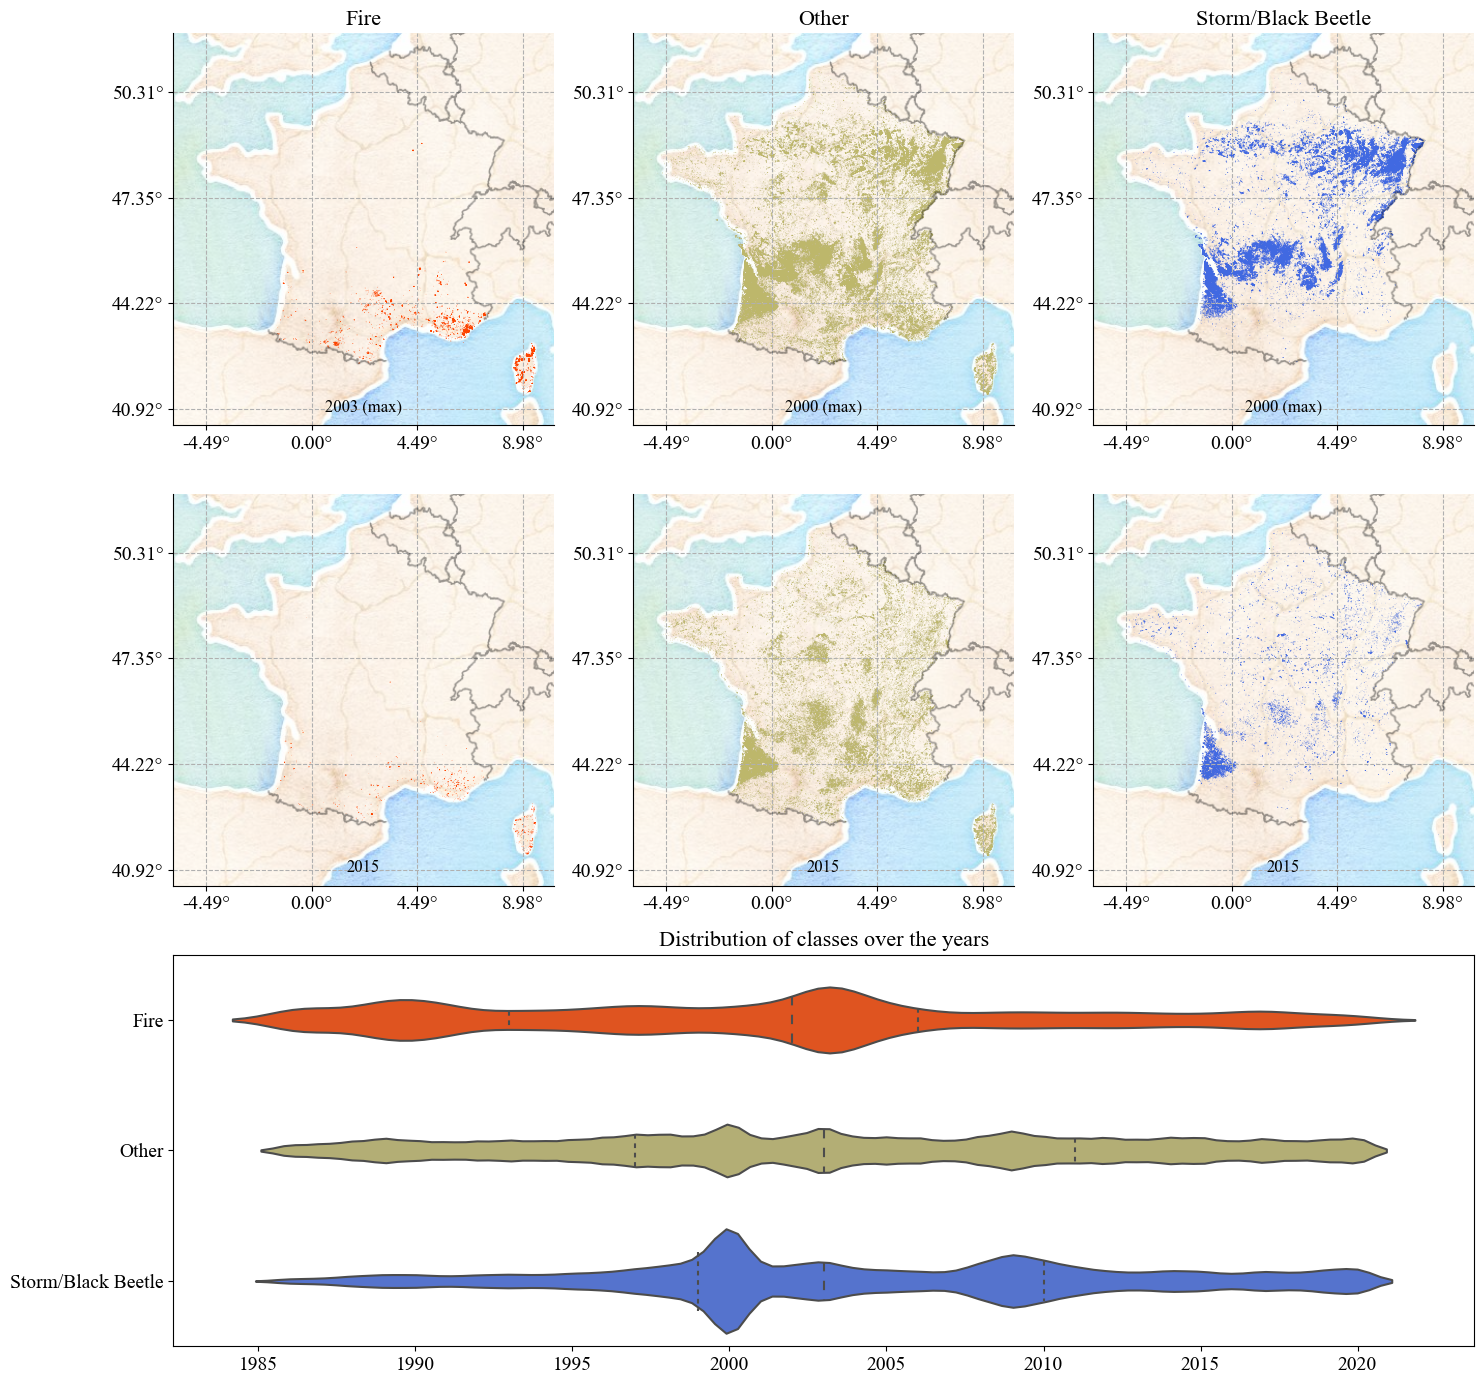

In [16]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from utils import pol_from_points
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math

# Set global font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Set global font size
plt.rcParams['font.size'] = 12  # Adjust as needed

# Additional font size settings
plt.rcParams['axes.labelsize'] = 14  # Font size for x and y labels
plt.rcParams['axes.titlesize'] = 16  # Font size for subplot titles
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels


# Setup the figure and axes using GridSpec
fig = plt.figure(figsize=(15, 14))
gs = GridSpec(3, 3, figure=fig)

class_names = data['class'].unique()

# Define colors for each class
custom_color_mapping = {
    'Fire': 'orangered',
    'Other': 'darkkhaki',
    'Storm/Black Beetle': 'royalblue',  # Yellow-brown

}

year = {
    'Fire': (2003, 2015),
    'Other': (2000, 2015),
    'Storm/Black Beetle': (2000, 2015)  # Yellow-brown

}

epsg = 3857
data.year = data.year.astype(int)
data = data[ data.geometry.area > 1000 ]
gdf_web_mercator = data.to_crs(epsg=epsg)
minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(50000).total_bounds
#build GeoDataFrame from the bounds
df = gpd.GeoDataFrame({'geometry': pol_from_points((minx, miny, maxx, maxy))}, index=[0], crs=f'epsg:{epsg}')

# Plot point clouds for each class in the first two rows
for idx, class_name in enumerate(sorted(class_names) * 2):
    row = idx // 3 
    col = idx % 3
    print(row, col)

    year_ = year[class_name][row]

    #get gdf and simplify 
    gdf = gdf_web_mercator[ (gdf_web_mercator['class'] == class_name) & (gdf_web_mercator['year'] == year_) ]
    gdf.geometry = gdf.geometry.simplify(1000)


    ax = fig.add_subplot(gs[row, col])

    df.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
    gdf[gdf['class'] == class_name].plot(ax=ax, color=custom_color_mapping[class_name], edgecolor=custom_color_mapping[class_name], alpha=1, linewidth=0.5)

    # Adding basemap with contextily
    cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Stamen.Watercolor, zoom=5, alpha=0.4)
    cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Stamen.TonerLines, zoom=5, alpha=0.4)
    # cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Esri.WorldGrayCanvas, zoom=5, alpha=0.5)
    
    if row == 0:
        ax.set_title(class_name)
    ax.axis('equal')
    ax.grid(True, linestyle='--')  # Add grid

    # # Setting the same extents for all plots
    ax.set_xlim((minx, maxx))
    ax.set_ylim((miny, maxy))


    if row < 2:
        
        # Using MultipleLocator to set tick locations
        ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
        ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

        # Using FuncFormatter to convert tick labels to lat/lon
        ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
        ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
        
        #annotate the year 1990 in bottom center of the plot
        if row == 0: 
            year_ = str(year_) + " (max)"
        ax.annotate(year_, xy=(0.5, 0), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=12, color='black', fontname='Times New Roman')
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


# Plot violin plots in the third row spanning all columns with normalized width
ax_violin = fig.add_subplot(gs[2, :])
sns.violinplot(x='year', y='class', data=data, ax=ax_violin, order=sorted(class_names),
               palette=custom_color_mapping, inner="quart", density_norm='width')
ax_violin.set_title('Distribution of classes over the years')
ax_violin.set_ylabel(None)
ax_violin.set_xlabel(None)
plt.tight_layout()
plt.show()


In [14]:
dpi = 200
fig.savefig(f'../figures/SenfSeidl_1984-2021_EPSG3857_FR_dpi{dpi}.png', dpi=dpi, bbox_inches='tight')